## Imports

In [50]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Data

In [51]:
data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

data

,age,gender,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,diploma,group_study,self_study,online_videos,coaching,mixed
0,17,1,2.78,92.9,1,7.4,0,0,2,58.9,1,0,0,0,1,0
1,22,1,7.88,76.8,1,8.5,0,2,1,90.3,0,0,0,0,1,0
2,20,0,0.89,71.6,1,9.8,0,0,1,43.7,1,0,0,0,1,0
3,23,1,3.48,65.4,1,4.2,2,0,1,58.2,0,0,0,0,0,1
4,17,0,1.35,69.0,1,7.4,1,2,2,53.7,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,17,1,5.74,81.4,1,7.5,2,2,2,95.0,0,0,0,1,0,0
13270,19,0,3.28,73.3,1,9.5,2,2,0,93.9,0,1,0,0,0,0
13271,18,1,3.71,41.6,0,5.9,1,1,1,60.9,0,0,0,0,1,0
13272,19,1,4.60,76.3,0,6.1,2,1,1,79.0,0,0,1,0,0,0


# Models

In [82]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('scaler', StandardScaler()),
                 ('features_selector',
                  SelectKBest(k=15,
                              score_func=<function f_regression at 0x7f26ce1c0680>)),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8207886710429086, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, e...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0059354140207009305, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_dept

# Friedman test

## Results for testing

In [83]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#TODO: Get models score
results = {n: [] for n in pipe_names}

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i # Use i to ensure different splits
    )

    for idx, model in enumerate(pipes.values()):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = r2_score(y_test, preds)

        results[pipe_names[idx]].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,0,1,2,3,4,5,6,7,8,9
XSB,0.716148,0.728192,0.714802,0.706387,0.723713,0.713968,0.721455,0.725883,0.715794,0.712093
Tree,0.631835,0.651890,0.633602,0.625912,0.636302,0.633652,0.639031,0.642365,0.632527,0.634088
SVR,0.716490,0.727786,0.720699,0.710897,0.721049,0.712867,0.718349,0.725742,0.713052,0.713354
Forest,0.696861,0.710447,0.699587,0.685231,0.702788,0.697402,0.705214,0.707736,0.699140,0.695951
Linear,0.724878,0.737702,0.727406,0.718213,0.732338,0.720628,0.728980,0.733838,0.723792,0.720419


# Friedman Test

In [86]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")

38.08000000000001
P-value: 1.0787747724399687e-07


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis

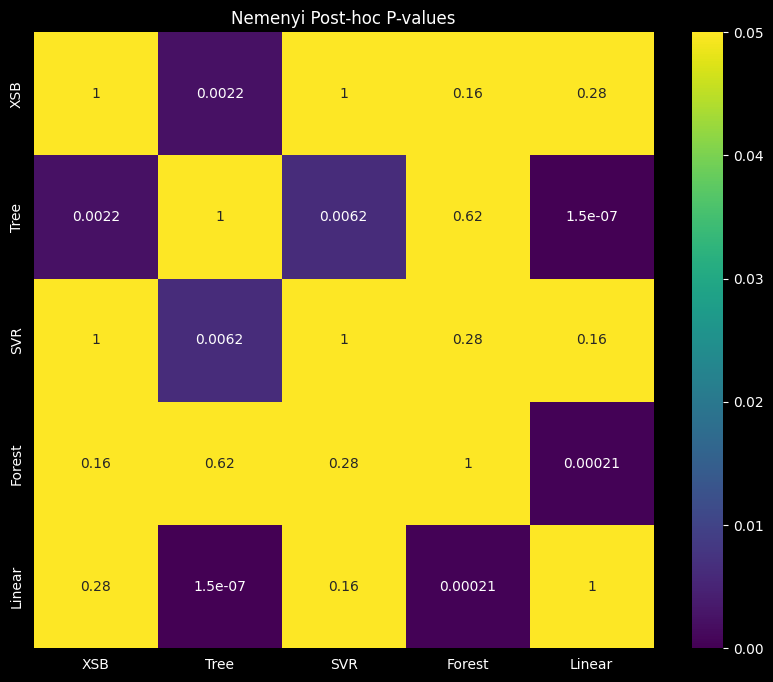

In [89]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)

plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Means of Model Results

In [94]:
results_df.mean(axis=1)

XSB       0.717843
Tree      0.636120
SVR       0.718028
Forest    0.700036
Linear    0.726820
dtype: float64